To Do: 

* EfficientNetB0

* MobileNetV2

* EfficientNetV2B3

* Resnet50

* DenseNet121

* InceptionV3

# **1-Checking GPU**

In [1]:
!nvidia-smi -L

GPU 0: NVIDIA GeForce GTX 1650 (UUID: GPU-53a3e216-6706-e120-b818-40b8c0b04c26)


# **2- Import Libraries**

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
tf.__version__

'2.9.1'

# **3- Import Functions from helping function**

In [4]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

# **4- import dataset**

In [5]:
pip install split-folders

Note: you may need to restart the kernel to use updated packages.


In [6]:
# import splitfolders

# splitfolders.ratio("../../data/", output="../../output_1",
#     seed=1337, ratio=(.8, .1, .1), group_prefix=None, move=False)

In [7]:
#How many images/classes are there?
walk_through_dir("../../output_1")

There are 3 directories and 0 images in '../../output_1'.
There are 37 directories and 0 images in '../../output_1\test'.
There are 0 directories and 63 images in '../../output_1\test\Apple__black_rot'.
There are 0 directories and 166 images in '../../output_1\test\Apple__healthy'.
There are 0 directories and 37 images in '../../output_1\test\Apple__rust'.
There are 0 directories and 70 images in '../../output_1\test\Apple__scab'.
There are 0 directories and 50 images in '../../output_1\test\Cassava__bacterial_blight'.
There are 0 directories and 57 images in '../../output_1\test\Cassava__brown_streak_disease'.
There are 0 directories and 48 images in '../../output_1\test\Cassava__green_mottle'.
There are 0 directories and 69 images in '../../output_1\test\Cassava__healthy'.
There are 0 directories and 45 images in '../../output_1\test\Cassava__mosaic_disease'.
There are 0 directories and 132 images in '../../output_1\test\Corn__common_rust'.
There are 0 directories and 110 images in '

In [8]:
train_dir_1 = "../../output_1/train/"
val_dir_1 = "../../output_1/val/"
test_dir_1 = "../../output_1/test"

In [9]:
#How many images/classes are there?
walk_through_dir("../../output_1")

There are 3 directories and 0 images in '../../output_1'.
There are 37 directories and 0 images in '../../output_1\test'.
There are 0 directories and 63 images in '../../output_1\test\Apple__black_rot'.
There are 0 directories and 166 images in '../../output_1\test\Apple__healthy'.
There are 0 directories and 37 images in '../../output_1\test\Apple__rust'.
There are 0 directories and 70 images in '../../output_1\test\Apple__scab'.
There are 0 directories and 50 images in '../../output_1\test\Cassava__bacterial_blight'.
There are 0 directories and 57 images in '../../output_1\test\Cassava__brown_streak_disease'.
There are 0 directories and 48 images in '../../output_1\test\Cassava__green_mottle'.
There are 0 directories and 69 images in '../../output_1\test\Cassava__healthy'.
There are 0 directories and 45 images in '../../output_1\test\Cassava__mosaic_disease'.
There are 0 directories and 132 images in '../../output_1\test\Corn__common_rust'.
There are 0 directories and 110 images in '

# **5- Setup data inputs**

In [10]:
# Set up data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1,
                                                                label_mode="categorical",
                                                                 batch_size=32,
                                                                image_size=IMG_SIZE,
                                                                 seed=42,
                                                                 shuffle=True)
val_data =  tf.keras.preprocessing.image_dataset_from_directory(val_dir_1,
                                                                 batch_size=32,                                                                
                                                                 label_mode="categorical",
                                                                 image_size=IMG_SIZE,
                                                                seed=42,
                                                                 shuffle=False) # don't shuffle test data for prediction analysis

test_data =  tf.keras.preprocessing.image_dataset_from_directory(test_dir_1,
                                                                 batch_size=32,                                                                
                                                                 label_mode="categorical",
                                                                 image_size=IMG_SIZE,
                                                                 seed=42,
                                                                 shuffle=False) # don't shuffle test data for prediction analysis

Found 39557 files belonging to 37 classes.
Found 4928 files belonging to 37 classes.
Found 4982 files belonging to 37 classes.


# **6- Create Checkpoint Callback**

In [11]:
# Create a checkpoint callback
checkpoint_path = "model_checkpoints"
from keras.callbacks import ModelCheckpoint, EarlyStopping

es = EarlyStopping(monitor="val_accuracy", min_delta=0.01, patience=2, verbose=1)

mc = ModelCheckpoint(monitor="val_accuracy",filepath=checkpoint_path, min_delta=0.01, patience=3, verbose=1, save_best_only=True)

cb = [es, mc]

# **7- Data Augmentation**

In [12]:
# Create a data augmentation layer to incorporate it right into the model
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Setup data augmentation
data_augmentation = Sequential([
   preprocessing.RandomFlip("horizontal"),
   preprocessing.RandomRotation(0.2),
   preprocessing.RandomHeight(0.2),
   preprocessing.RandomWidth(0.2),
   preprocessing.RandomZoom(0.2),
  # preprocessing.Rescaling(1/255.)  # rescale inputs of images between 1 & 0, required for models like ResNet50                            
], name= "data_augmentation")



# **Model 1 (EfficientNetB0)**

In [13]:
# Setup a base model and freeze its layer (this will extract features)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup a model architecture with trainable top layers
inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
x = data_augmentation(inputs) # augment layers (only happens during trainable phase)
x = base_model(x, training=False) # put the base model in interface mode so weights which needs to be frozen, stay frozen
x = layers.GlobalAveragePooling2D(name="global_avg_pooling_layer")(x)
outputs = layers.Dense(len(train_data.class_names), activation="softmax", name="output_layer")(x)
model=tf.keras.Model(inputs, outputs)

In [14]:
# Get a summary of model we've been created
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_avg_pooling_layer (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 output_layer (Dense)        (None, 37)                47397     
                                                                 
Total params: 4,096,968
Trainable params: 47,397
Non-trainabl

## **14-Applying Feature Extraction**

In [15]:
from tensorflow.keras import metrics

METRICS = [
      metrics.TruePositives(name='tp'),
      metrics.FalsePositives(name='fp'),
      metrics.TrueNegatives(name='tn'),
      metrics.FalseNegatives(name='fn'), 
      metrics.CategoricalAccuracy(name='accuracy'),
      metrics.Precision(name='precision'),
      metrics.Recall(name='recall'),
      metrics.AUC(name='auc')
]

In [16]:
# Compile
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=METRICS)

# Fit
history = model.fit(train_data,
                    epochs=5, # fit to 5 epochs to keep experiment quick
                    validation_data=val_data,
                    validation_steps=len(val_data))

Epoch 1/5
1237/1237 [==============================] - 2459s 2s/step - loss: 0.6781 - tp: 27082.0000 - fp: 1445.0000 - tn: 1422607.0000 - fn: 12475.0000 - accuracy: 0.8231 - precision: 0.9493 - recall: 0.6846 - auc: 0.9934 - val_loss: 0.3871 - val_tp: 4078.0000 - val_fp: 251.0000 - val_tn: 177157.0000 - val_fn: 850.0000 - val_accuracy: 0.8864 - val_precision: 0.9420 - val_recall: 0.8275 - val_auc: 0.9970
Epoch 2/5
1237/1237 [==============================] - 2354s 2s/step - loss: 0.3158 - tp: 34117.0000 - fp: 1642.0000 - tn: 1422410.0000 - fn: 5440.0000 - accuracy: 0.9108 - precision: 0.9541 - recall: 0.8625 - auc: 0.9980 - val_loss: 0.3051 - val_tp: 4309.0000 - val_fp: 245.0000 - val_tn: 177163.0000 - val_fn: 619.0000 - val_accuracy: 0.9093 - val_precision: 0.9462 - val_recall: 0.8744 - val_auc: 0.9974
Epoch 3/5
1237/1237 [==============================] - 2351s 2s/step - loss: 0.2515 - tp: 35262.0000 - fp: 1588.0000 - tn: 1422464.0000 - fn: 4295.0000 - accuracy: 0.9251 - precision: 0

## **15-Evaluate Whole Dataset**

In [17]:
# Evaluate on the whole test dataset  ##its a feature extraction instead of fine tune
feature_extraction_results = model.evaluate(test_data)
feature_extraction_results

156/156 [==============================] - 245s 2s/step - loss: 0.2106 - tp: 4561.0000 - fp: 223.0000 - tn: 179129.0000 - fn: 421.0000 - accuracy: 0.9356 - precision: 0.9534 - recall: 0.9155 - auc: 0.9980


[0.21061289310455322,
 4561.0,
 223.0,
 179129.0,
 421.0,
 0.9355680346488953,
 0.9533863067626953,
 0.9154958128929138,
 0.9980231523513794]

## **16-Graph of Feature Extraction**

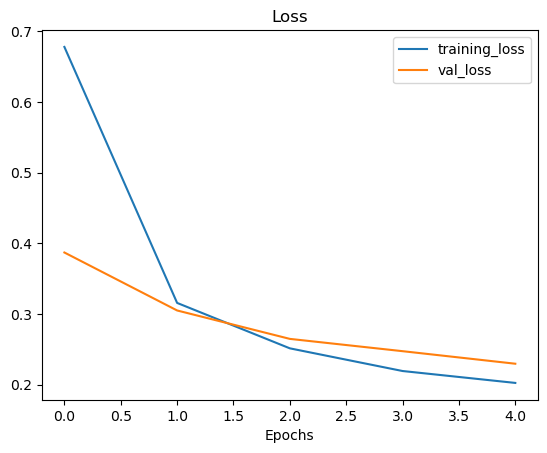

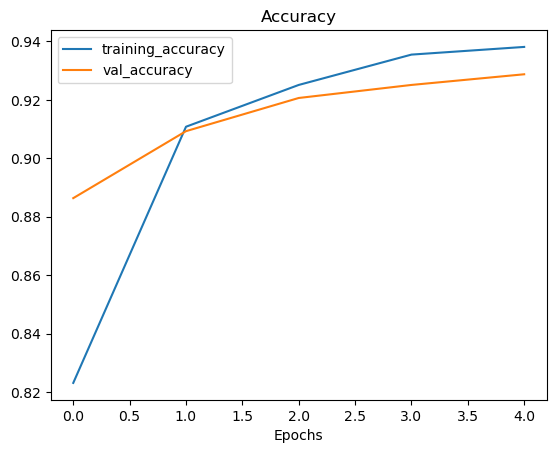

In [18]:
plot_loss_curves(history)

## **17-Fine-Tuning Model Using EfficientNetB0**

In [19]:
# Unfreeze all of the layers in base model
base_model.trainable=True

# Refreeze every layer except the last 5 layer 
for layer in base_model.layers[:-5]:
  layer.trainable=False

In [20]:
# Recompile model with lower learning rate (it's typically best practice to lower the learning rate when fine-tuning)
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # learning rate lower by 10x
              metrics=METRICS)

In [21]:
# What layers in the model are trainable?
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_avg_pooling_layer True
output_layer True


In [22]:
# Check which layers in our model is trainable
for layer_number, layer in enumerate(model.layers[2].layers):
  print(layer_number, layer.name, layer.trainable )

0 input_1 False
1 rescaling False
2 normalization False
3 tf.math.truediv False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [23]:
# Fine-tune for more 5 epochs
fine_tune_epochs = 5 # model has already done the 5 epochs (feature extraction), this is the total number of epochs we're after (5 + 5 =10)

# Fine-tune our model
history_fine_tune = model.fit(train_data,
                              epochs=fine_tune_epochs,
                              validation_data=val_data,
                              validation_steps=len(val_data),
                              initial_epoch=history.epoch[-1])

Epoch 5/5
1237/1237 [==============================] - 2270s 2s/step - loss: 0.1682 - tp: 41444.0000 - fp: 1673.0000 - tn: 1601731.0000 - fn: 3095.0000 - accuracy: 0.9442 - precision: 0.9612 - recall: 0.9305 - auc: 0.9986 - val_loss: 0.1889 - val_tp: 4586.0000 - val_fp: 222.0000 - val_tn: 177186.0000 - val_fn: 342.0000 - val_accuracy: 0.9403 - val_precision: 0.9538 - val_recall: 0.9306 - val_auc: 0.9976


## **18- Evaluate Fine-Tune Model**

In [24]:
# Evaluate on the whole test dataset
fine_tune_results =model.evaluate(test_data)
fine_tune_results

156/156 [==============================] - 249s 2s/step - loss: 0.1750 - tp: 4647.0000 - fp: 229.0000 - tn: 179123.0000 - fn: 335.0000 - accuracy: 0.9436 - precision: 0.9530 - recall: 0.9328 - auc: 0.9980


[0.17496658861637115,
 4647.0,
 229.0,
 179123.0,
 335.0,
 0.9435969591140747,
 0.953035295009613,
 0.9327579140663147,
 0.9980145692825317]

## **19-Compare The Histories**

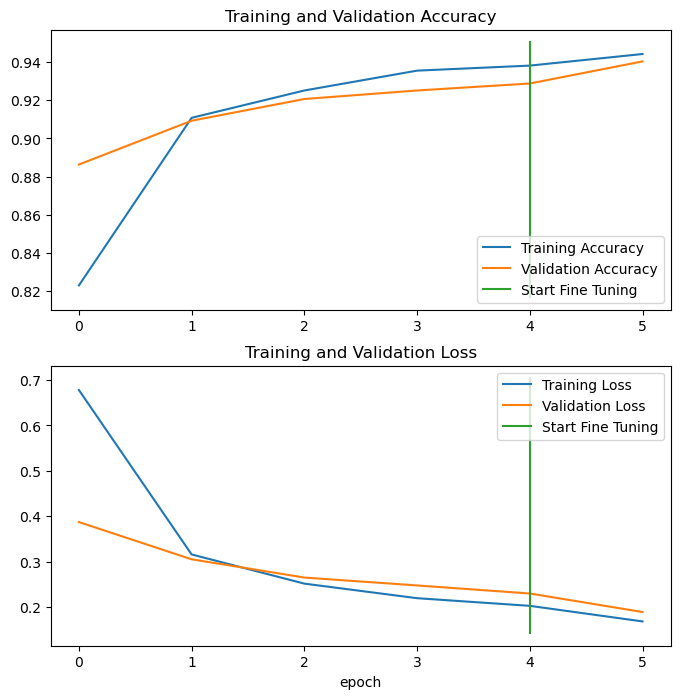

In [25]:
# Compare the historys of feature extraction model with fine-tuning model 
compare_historys(original_history=history,
                 new_history=history_fine_tune,
                 initial_epochs=5)

## **20-Saving and Loading The Model**

In [26]:
model.save('models/plant_disease_detector')

INFO:tensorflow:Assets written to: models/plant_disease_detector\assets


INFO:tensorflow:Assets written to: models/plant_disease_detector\assets


## **Make Prediction with Trained Model**

In [27]:
# Make predictions with model
preds_probs = model.predict(test_data, verbose=1) # set verbosity to see how long it left

156/156 [==============================] - 234s 1s/step


In [28]:
len(test_data)

156

In [29]:
# How many predictions are there?
len(preds_probs)

4982

In [30]:
# What's the shape of our predictions?
preds_probs.shape

(4982, 37)

In [31]:
# Let's see whats the first 10 predictions looks like
preds_probs[:10]

array([[7.79386461e-01, 3.19959770e-04, 1.02687271e-04, 2.18477160e-01,
        5.72480019e-09, 7.08619474e-09, 6.75370293e-09, 7.46336184e-08,
        2.68059219e-09, 2.68924022e-10, 6.96613101e-10, 3.27310748e-11,
        1.18198750e-06, 5.05204953e-04, 1.78036877e-04, 1.12199632e-06,
        1.97962087e-04, 1.89168674e-07, 2.08066893e-07, 1.28731070e-09,
        4.19139612e-10, 1.66836336e-11, 1.03992181e-06, 1.14584546e-08,
        9.30905557e-08, 5.43088709e-06, 5.75589365e-04, 2.99616723e-08,
        1.08525746e-05, 4.77226479e-07, 3.27377165e-06, 4.36133547e-08,
        4.76204434e-07, 2.11051927e-04, 7.90936827e-09, 2.14196207e-05,
        4.28199742e-09],
       [9.99202192e-01, 3.22315259e-07, 7.45531850e-07, 8.23514711e-07,
        2.01977501e-09, 3.13280124e-10, 3.25824567e-09, 1.32029312e-08,
        4.68916961e-10, 1.40384193e-09, 8.71020944e-09, 1.30057659e-10,
        1.92309557e-10, 8.50760973e-09, 2.87742843e-08, 1.72401808e-08,
        7.85773678e-04, 8.19597989e-09,

In [32]:
# What does the first prediction probability array look like?
preds_probs[0], len(preds_probs[0]), sum(preds_probs[0])

(array([7.7938646e-01, 3.1995977e-04, 1.0268727e-04, 2.1847716e-01,
        5.7248002e-09, 7.0861947e-09, 6.7537029e-09, 7.4633618e-08,
        2.6805922e-09, 2.6892402e-10, 6.9661310e-10, 3.2731075e-11,
        1.1819875e-06, 5.0520495e-04, 1.7803688e-04, 1.1219963e-06,
        1.9796209e-04, 1.8916867e-07, 2.0806689e-07, 1.2873107e-09,
        4.1913961e-10, 1.6683634e-11, 1.0399218e-06, 1.1458455e-08,
        9.3090556e-08, 5.4308871e-06, 5.7558937e-04, 2.9961672e-08,
        1.0852575e-05, 4.7722648e-07, 3.2737717e-06, 4.3613355e-08,
        4.7620443e-07, 2.1105193e-04, 7.9093683e-09, 2.1419621e-05,
        4.2819974e-09], dtype=float32),
 37,
 1.0000000741109245)

In [33]:
# We get one prediction probability per class(in our case there's 101 prediction probabilities)
print(f"Number of prediction probabilites for sample 0: {len(preds_probs[0])}")
print(f"What prediction probabilites sample 0 looks like:\n {preds_probs[0]}")
print(f"The class with highest predicted probability by the model for sample 0: {preds_probs[0].argmax()}")


Number of prediction probabilites for sample 0: 37
What prediction probabilites sample 0 looks like:
 [7.7938646e-01 3.1995977e-04 1.0268727e-04 2.1847716e-01 5.7248002e-09
 7.0861947e-09 6.7537029e-09 7.4633618e-08 2.6805922e-09 2.6892402e-10
 6.9661310e-10 3.2731075e-11 1.1819875e-06 5.0520495e-04 1.7803688e-04
 1.1219963e-06 1.9796209e-04 1.8916867e-07 2.0806689e-07 1.2873107e-09
 4.1913961e-10 1.6683634e-11 1.0399218e-06 1.1458455e-08 9.3090556e-08
 5.4308871e-06 5.7558937e-04 2.9961672e-08 1.0852575e-05 4.7722648e-07
 3.2737717e-06 4.3613355e-08 4.7620443e-07 2.1105193e-04 7.9093683e-09
 2.1419621e-05 4.2819974e-09]
The class with highest predicted probability by the model for sample 0: 0


In [34]:
# Get the pred classes of each model
pred_classes = preds_probs.argmax(axis=1)

# How do they look like?
pred_classes[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [35]:
# How many pred classes we have?
len(pred_classes)

4982

In [36]:
# To get our test dataset labels we need to unravel our test_data BatchDataset
y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax()) # currently test labels look like: [0, 0, 0, 1,.....0,0], we want the index value where the index value "1" occurs
y_labels[:10] # look at the first 10 

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [37]:
# How many y_labels are there?
len(y_labels)

4982

## **22 Confusion Matrix**

In [38]:
# The results from the saved model (Above) should be very similar to the results below
fine_tune_results

[0.17496658861637115,
 4647.0,
 229.0,
 179123.0,
 335.0,
 0.9435969591140747,
 0.953035295009613,
 0.9327579140663147,
 0.9980145692825317]

In [53]:
import json
# Get a list of class names
class_names =test_data.class_names
class_names[:10]


# Save class_name_lookup as a JSON file
with open('class_names.json', 'w') as f:
    json.dump(class_names, f)

NameError: name 'json' is not defined

In [40]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# We need to make some changes to our make_confusion_matrix function to ensure the x-label print verticaly
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### changes (x-labels vertically) ###
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

In [41]:
make_confusion_matrix(y_true=y_labels,
                       y_pred=pred_classes,
                       classes=class_names,
                      figsize=(100, 100),
                      text_size=20,
                      savefig=True)

## **23- Classification Report**

In [42]:
from sklearn.metrics import classification_report
print(classification_report(y_true=y_labels,
                            y_pred=pred_classes))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        63
           1       0.95      0.99      0.97       166
           2       0.97      0.89      0.93        37
           3       0.92      0.87      0.90        70
           4       0.59      0.54      0.56        50
           5       0.69      0.47      0.56        57
           6       0.71      0.67      0.69        48
           7       0.57      0.78      0.66        69
           8       0.77      0.76      0.76        45
           9       0.98      0.97      0.98       132
          10       0.96      0.99      0.97       110
          11       1.00      0.99      1.00       117
          12       0.99      0.94      0.97       139
          13       0.99      1.00      0.99      1139
          14       0.98      0.98      0.98        47
          15       0.98      1.00      0.99        90
          16       0.97      1.00      0.99       231
          17       1.00    

In [43]:
# Get a dictionary of the classification report
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

{'0': {'precision': 0.984375,
  'recall': 1.0,
  'f1-score': 0.9921259842519685,
  'support': 63.0},
 '1': {'precision': 0.9482758620689655,
  'recall': 0.9939759036144579,
  'f1-score': 0.9705882352941175,
  'support': 166.0},
 '2': {'precision': 0.9705882352941176,
  'recall': 0.8918918918918919,
  'f1-score': 0.9295774647887325,
  'support': 37.0},
 '3': {'precision': 0.9242424242424242,
  'recall': 0.8714285714285714,
  'f1-score': 0.8970588235294117,
  'support': 70.0},
 '4': {'precision': 0.5869565217391305,
  'recall': 0.54,
  'f1-score': 0.5625000000000001,
  'support': 50.0},
 '5': {'precision': 0.6923076923076923,
  'recall': 0.47368421052631576,
  'f1-score': 0.5625,
  'support': 57.0},
 '6': {'precision': 0.7111111111111111,
  'recall': 0.6666666666666666,
  'f1-score': 0.6881720430107527,
  'support': 48.0},
 '7': {'precision': 0.574468085106383,
  'recall': 0.782608695652174,
  'f1-score': 0.6625766871165644,
  'support': 69.0},
 '8': {'precision': 0.7727272727272727,
  '

In [52]:
class_names

['Apple__black_rot',
 'Apple__healthy',
 'Apple__rust',
 'Apple__scab',
 'Cassava__bacterial_blight',
 'Cassava__brown_streak_disease',
 'Cassava__green_mottle',
 'Cassava__healthy',
 'Cassava__mosaic_disease',
 'Corn__common_rust',
 'Corn__gray_leaf_spot',
 'Corn__healthy',
 'Grape__black_measles',
 'Grape__black_rot',
 'Grape__healthy',
 'Grape__leaf_blight_(isariopsis_leaf_spot)',
 'Peach__bacterial_spot',
 'Peach__healthy',
 'Pepper_bell__bacterial_spot',
 'Pepper_bell__healthy',
 'Pomegranate__diseased',
 'Pomegranate__healthy',
 'Potato__early_blight',
 'Potato__healthy',
 'Potato__late_blight',
 'Strawberry___leaf_scorch',
 'Strawberry__healthy',
 'Tomato__bacterial_spot',
 'Tomato__early_blight',
 'Tomato__healthy',
 'Tomato__late_blight',
 'Tomato__leaf_mold',
 'Tomato__mosaic_virus',
 'Tomato__septoria_leaf_spot',
 'Tomato__spider_mites_(two_spotted_spider_mite)',
 'Tomato__target_spot',
 'Tomato__yellow_leaf_curl_virus']

In [45]:
classification_report_dict["7"]["f1-score"]

0.6625766871165644

In [46]:
# Create empty dictionary
class_f1_scores = {}
# Loop through classification report dictionary items
for k, v in classification_report_dict.items():
  if k == "accuracy": # stop once we get to accuracy key
    break
  else:
     # Add names and f1-scores to new dictionary
     class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores     


{'Apple__black_rot': 0.9921259842519685,
 'Apple__healthy': 0.9705882352941175,
 'Apple__rust': 0.9295774647887325,
 'Apple__scab': 0.8970588235294117,
 'Cassava__bacterial_blight': 0.5625000000000001,
 'Cassava__brown_streak_disease': 0.5625,
 'Cassava__green_mottle': 0.6881720430107527,
 'Cassava__healthy': 0.6625766871165644,
 'Cassava__mosaic_disease': 0.7640449438202247,
 'Corn__common_rust': 0.9770992366412214,
 'Corn__gray_leaf_spot': 0.9732142857142858,
 'Corn__healthy': 0.9957081545064378,
 'Grape__black_measles': 0.966789667896679,
 'Grape__black_rot': 0.9938757655293089,
 'Grape__healthy': 0.9787234042553191,
 'Grape__leaf_blight_(isariopsis_leaf_spot)': 0.989010989010989,
 'Peach__bacterial_spot': 0.9871794871794872,
 'Peach__healthy': 0.9722222222222222,
 'Pepper_bell__bacterial_spot': 0.9383886255924171,
 'Pepper_bell__healthy': 0.964401294498382,
 'Pomegranate__diseased': 0.9642857142857143,
 'Pomegranate__healthy': 0.9666666666666667,
 'Potato__early_blight': 0.94642857

In [47]:
# Turn f1 scores into Dataframe visualization
import pandas as pd
f1_scores =pd.DataFrame({"class_names": list(class_f1_scores.keys()),
                        "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)
f1_scores                        

,class_names,f1-score
11,Corn__healthy,0.995708
13,Grape__black_rot,0.993876
0,Apple__black_rot,0.992126
15,Grape__leaf_blight_(isariopsis_leaf_spot),0.989011
16,Peach__bacterial_spot,0.987179
25,Strawberry___leaf_scorch,0.986547
36,Tomato__yellow_leaf_curl_virus,0.984227
26,Strawberry__healthy,0.979167
14,Grape__healthy,0.978723
9,Corn__common_rust,0.977099


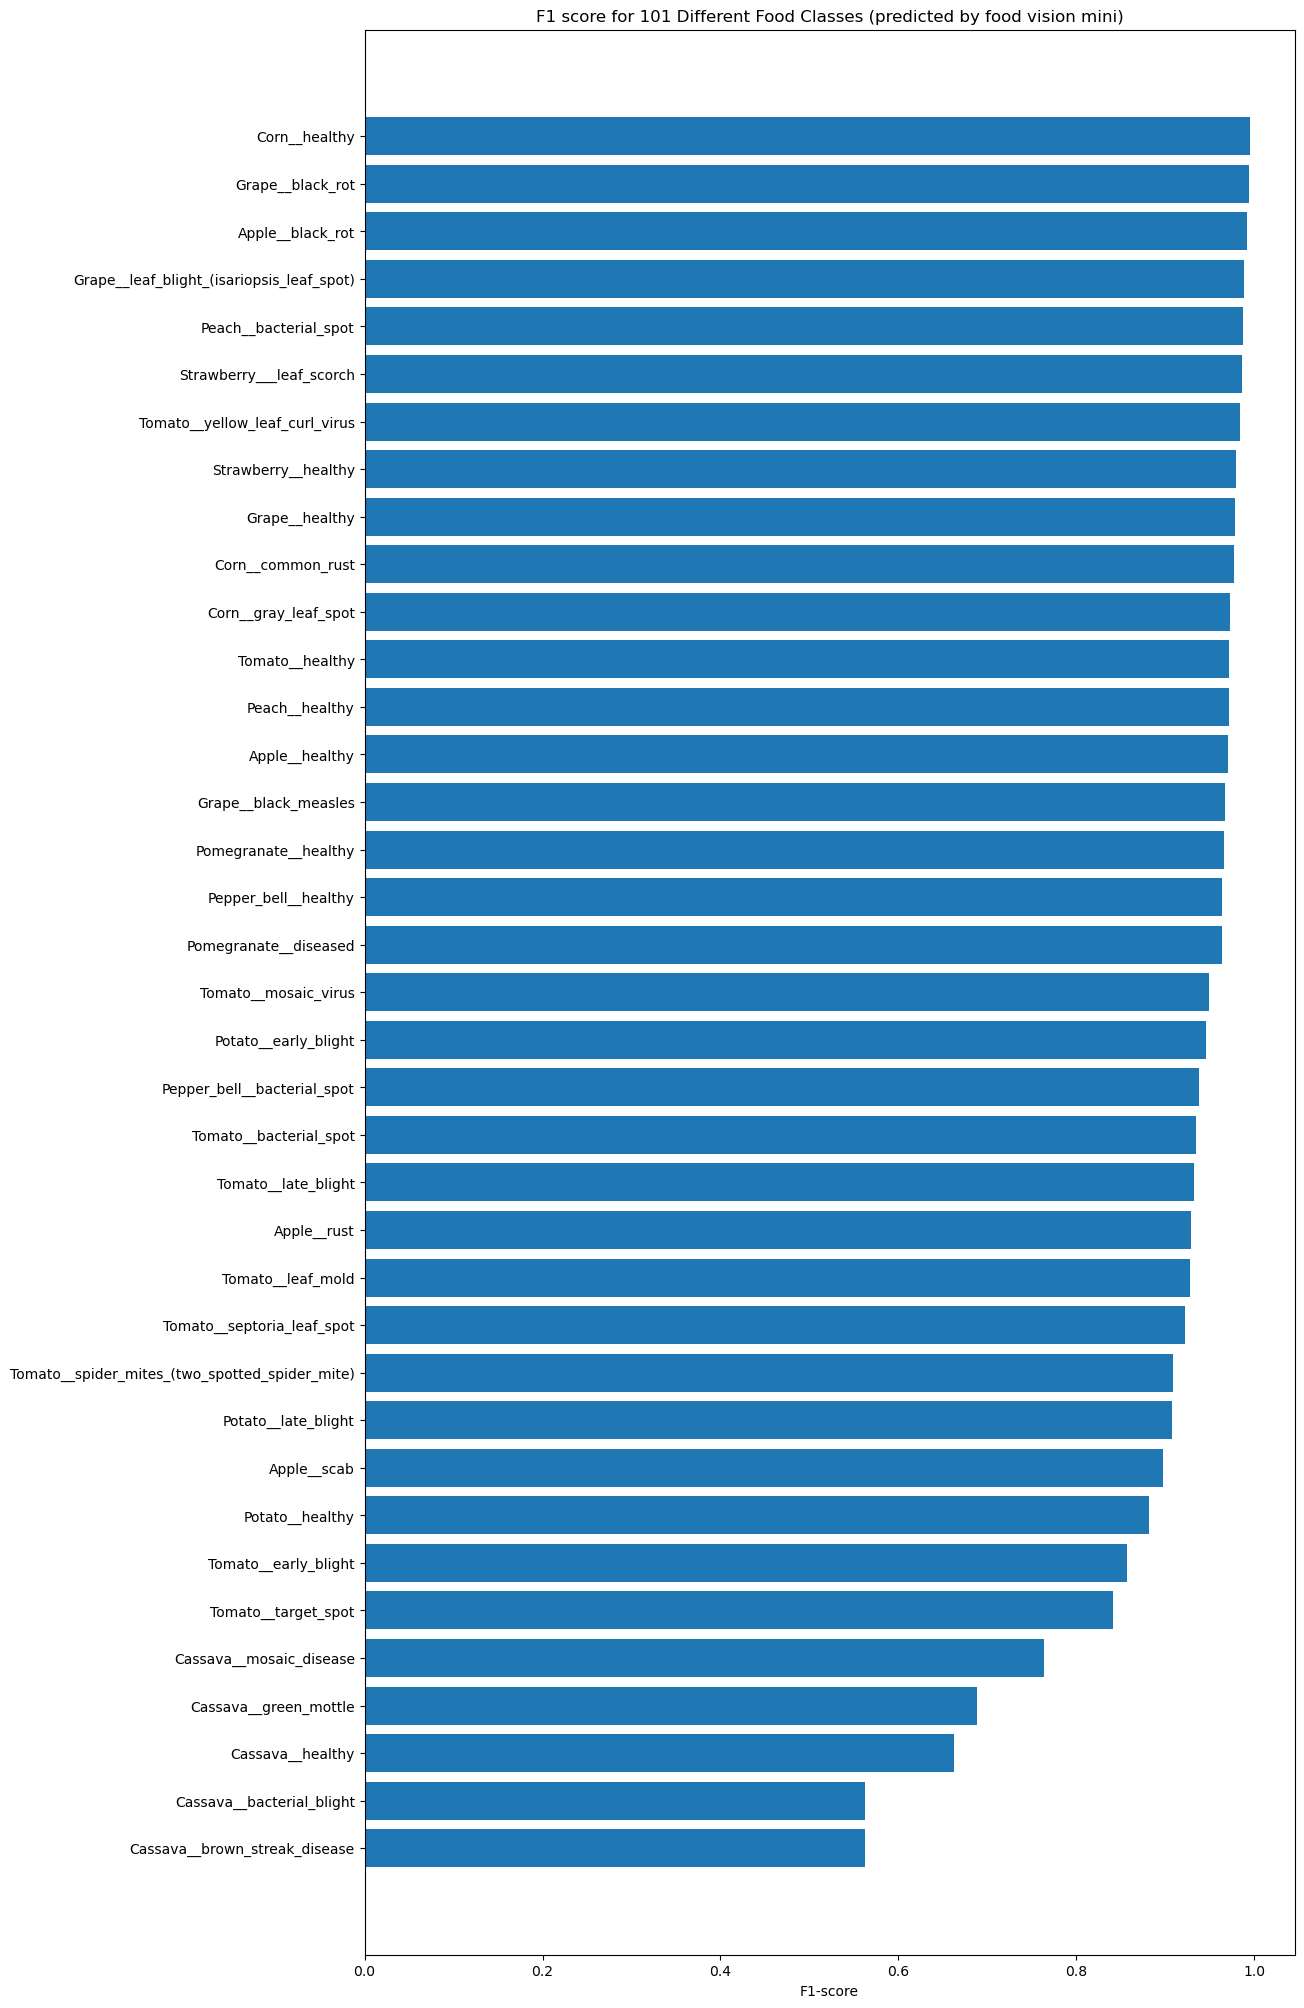

In [48]:
import matplotlib.pyplot as plt


import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values) # get f1-score value
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores["class_names"])
ax.set_xlabel("F1-score")
ax.set_title("F1 score for 101 Different Food Classes (predicted by food vision mini)")
ax.invert_yaxis(); # reverse the order of our plot
fig.savefig("f1-score.png")


# Challenge: add value to the end of each bar of what the actual f1-score is 
# (hint: use the "autolabel" function from here: https://matplotlib.org/2.0.2/examples/api/barchart_demo.html) 

In [49]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("model.tflite", "wb") as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\m7abu\AppData\Local\Temp\tmpr39rr_fo\assets


INFO:tensorflow:Assets written to: C:\Users\m7abu\AppData\Local\Temp\tmpr39rr_fo\assets
